In [1]:
# === ETAPE 1 : Diagnostic manquants/zero sur Income + impact sur Response ===
import pandas as pd
import numpy as np

# 0) Charger le CSV (adapte le chemin/nom si besoin)
PATH = "Campagne_Market.csv"   # <- change si ton fichier a un autre nom
df = pd.read_csv(PATH, engine="python", sep=None, encoding="utf-8-sig")
df.columns = [str(c).strip() for c in df.columns]

# 1) Conversions minimales utiles
if "Dt_Customer" in df.columns:
    df["Dt_Customer"] = pd.to_datetime(df["Dt_Customer"], errors="coerce", dayfirst=True)
for c in ["Income","Response","Year_Birth","Recency","NumWebVisitsMonth",
          "NumDealsPurchases","NumWebPurchases","NumCatalogPurchases","NumStorePurchases",
          "MntWines","MntFruits","MntMeatProducts","MntFishProducts","MntSweetProducts","MntGoldProds"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# 2) Variables auxiliaires (Age, PastAccepted)
ref_date = df["Dt_Customer"].max() if "Dt_Customer" in df.columns else pd.Timestamp.today().normalize()
df["Age"] = (ref_date.year - pd.to_numeric(df.get("Year_Birth"), errors="coerce")).astype("Int64")

past_cols = [c for c in ["AcceptedCmp1","AcceptedCmp2","AcceptedCmp3","AcceptedCmp4","AcceptedCmp5"] if c in df.columns]
df["PastAccepted"] = df[past_cols].sum(axis=1) if past_cols else 0

# 3) Totaux utiles
mnt_cols = [c for c in ["MntWines","MntFruits","MntMeatProducts","MntFishProducts","MntSweetProducts","MntGoldProds"] if c in df.columns]
buy_cols = [c for c in ["NumDealsPurchases","NumWebPurchases","NumCatalogPurchases","NumStorePurchases"] if c in df.columns]
df["TotalMnt"] = df[mnt_cols].sum(axis=1, skipna=True) if mnt_cols else np.nan
df["TotalPurchases"] = df[buy_cols].sum(axis=1, skipna=True) if buy_cols else np.nan
df["DealsShare"] = np.where((df["TotalPurchases"]>0) & (~df["TotalPurchases"].isna()),
                            df.get("NumDealsPurchases", 0) / df["TotalPurchases"], np.nan)

# 4) Flags sur le revenu
df["Income_missing"] = df["Income"].isna()
df["Income_is_zero"] = (df["Income"] == 0)

# 5) Sorties à partager
print("== Comptes Income (Missing vs Zéro) ==")
print(df[["Income_missing","Income_is_zero"]].value_counts(dropna=False))

print("\n== Taux de réponse (Response) selon Income_missing ==")
tr_miss = df.groupby("Income_missing")["Response"].mean().round(3)
print(tr_miss)

print("\n== Statistiques clés par Income_missing ==")
desc = df.groupby("Income_missing")[["Age","Recency","TotalPurchases","TotalMnt","NumWebVisitsMonth"]].agg(["median","mean"]).round(2)
print(desc)


== Comptes Income (Missing vs Zéro) ==
Income_missing  Income_is_zero
False           False             2216
True            False               24
Name: count, dtype: int64

== Taux de réponse (Response) selon Income_missing ==
Income_missing
False    0.150
True     0.042
Name: Response, dtype: float64

== Statistiques clés par Income_missing ==
                  Age        Recency        TotalPurchases        TotalMnt  \
               median   mean  median   mean         median   mean   median   
Income_missing                                                               
False            44.0  45.18    49.0  49.01           15.0  14.88    396.5   
True             44.5  46.54    62.0  58.04           10.5  13.12    262.0   

                       NumWebVisitsMonth        
                  mean            median  mean  
Income_missing                                  
False           607.08               6.0  5.32  
True            487.88               6.0  5.08  


## Interprétation de l’étape 1 — Diagnostic des valeurs manquantes du revenu (`Income`)

### 🔹 Objectif

L’objectif de cette première étape était de **comprendre la nature et l’impact** des valeurs manquantes dans la variable `Income`.
Avant de procéder à toute imputation, il est important d’analyser :

* combien d’observations sont concernées par des valeurs manquantes,
* si ces valeurs manquantes sont aléatoires ou associées à des caractéristiques particulières,
* et si elles influencent la probabilité de réponse à la campagne (`Response`).


### 🔹 Analyse des effectifs

Le jeu de données contient :

* **2 216 individus avec un revenu renseigné**,
* **24 individus sans revenu déclaré**,
  soit **environ 1,1 % de valeurs manquantes** sur cette variable.

Même si cette proportion est faible, il est essentiel de les conserver pour évaluer si ces individus présentent un comportement distinct des autres, car une suppression directe pourrait introduire un biais dans l’analyse.


### 🔹 Impact sur le taux de réponse à la campagne

| Groupe                                    | Taux de réponse moyen |
| ----------------------------------------- | --------------------: |
| Revenu connu (`Income_missing = False`)   |            **15,0 %** |
| Revenu manquant (`Income_missing = True`) |             **4,2 %** |

On observe une différence marquée :
les clients sans revenu déclaré répondent **près de quatre fois moins** à la campagne que ceux disposant d’un revenu renseigné.
Cela suggère que la présence de valeurs manquantes **n’est pas aléatoire**.
Ces individus semblent appartenir à un segment **moins réactif ou moins engagé**, ce qui correspond davantage à un mécanisme de manquance de type **MAR (Missing At Random)** ou **MNAR (Missing Not At Random)**.

En pratique, cela signifie que **le fait de ne pas renseigner son revenu est lié à d’autres caractéristiques observables ou à un comportement spécifique** (par exemple une moindre interaction commerciale ou un niveau socio-économique plus bas).


### 🔹 Comparaison des profils entre les deux groupes

L’analyse descriptive met en évidence les différences suivantes :

| Variable                    | Revenu connu | Revenu manquant | Interprétation                                     |
| --------------------------- | ------------ | --------------- | -------------------------------------------------- |
| Âge moyen                   | 45,2 ans     | 46,5 ans        | profils similaires en âge                          |
| Récence moyenne             | 49 jours     | 58 jours        | les clients sans revenu ont acheté moins récemment |
| Total Purchases (moy.)      | 14,9         | 13,1            | fréquence d’achat plus faible                      |
| Total Mnt (moy.)            | 607 €        | 488 €           | dépenses globales plus faibles                     |
| Num Web Visits Month (moy.) | 5,3          | 5,1             | activité en ligne comparable                       |

Les clients dont le revenu est manquant réalisent **moins d’achats**, dépensent **moins en moyenne**, et présentent une **récence d’achat plus élevée** (c’est-à-dire qu’ils n’ont pas acheté depuis plus longtemps).
Cela confirme que ces individus constituent une population **moins active commercialement**.

---

### 🔹 Interprétation globale

On peut en conclure que :

* Les **valeurs manquantes du revenu** ne sont **pas dues au hasard**, mais probablement à des facteurs socio-économiques ou comportementaux.
* Ces individus forment un groupe **plus distant vis-à-vis de la marque**, avec un **taux de réponse nettement inférieur** et une **activité d’achat réduite**.
* Supprimer ces lignes reviendrait à **éliminer un segment spécifique du portefeuille client**, ce qui fausserait les analyses globales.


### Conclusion

Les valeurs manquantes sur `Income` doivent donc être **conservées** dans le jeu de données.
Pour la suite, on a choisi de les **traiter par imputation hiérarchique**, tout en gardant la variable **`Income_missing`** comme **indicateur analytique**.
Cela permettra de maintenir l’intégrité statistique du dataset et d’étudier séparément le comportement de ce groupe dans les étapes suivantes (analyses descriptives, modélisation, etc.).


In [2]:
# === ETAPE 2 : Imputation hiérarchique de Income avec regroupement personnalisé ===
import pandas as pd
import numpy as np

# 1) Vérifier que les colonnes nécessaires existent
print("Colonnes dispo :", [c for c in ["Income","Education","Marital_Status","Age"] if c in df.columns])

# 2) Nettoyer/standardiser Marital_Status selon ta règle métier
#    - "Alone" -> "Single" (même situation de vie)
#    - "YOLO" et "Absurd" -> "Other" (valeurs aberrantes)
def clean_marital(x):
    if x == "Alone":
        return "Single"
    elif x in ["YOLO", "Absurd"]:
        return "Other"
    else:
        return x

df["Marital_Status_clean"] = df["Marital_Status"].apply(clean_marital)

# 3) Créer des tranches d’âge (bins) pour stabiliser les calculs de médiane
#    (on évite de travailler à l’âge exact, qui peut créer des groupes trop petits)
df["Age_bin"] = pd.cut(
    df["Age"],
    bins=[0,25,35,45,55,65,200],
    labels=["≤25","26–35","36–45","46–55","56–65",">65"]
)

# 4) Calculer les médianes hiérarchiques sur Income :
#    Niveau 1 (le plus spécifique) : Education x Marital_Status_clean x Age_bin
#    Niveau 2 (fallback)          : Education x Age_bin
#    Niveau 3 (ultime fallback)   : médiane globale
med_full   = df.groupby(["Education","Marital_Status_clean","Age_bin"], dropna=False)["Income"].median()
med_ea     = df.groupby(["Education","Age_bin"], dropna=False)["Income"].median()
med_global = df["Income"].median()

# 5) Fonction d’imputation : on garde la valeur réelle si elle existe.
#    Sinon on prend la médiane du groupe complet -> sinon groupe réduit -> sinon médiane globale.
def impute_income(row):
    if not pd.isna(row["Income"]):
        return row["Income"]
    k_full = (row["Education"], row["Marital_Status_clean"], row["Age_bin"])
    if k_full in med_full.index and not pd.isna(med_full.loc[k_full]):
        return med_full.loc[k_full]
    k_ea = (row["Education"], row["Age_bin"])
    if k_ea in med_ea.index and not pd.isna(med_ea.loc[k_ea]):
        return med_ea.loc[k_ea]
    return med_global

# 6) Appliquer l’imputation à toutes les lignes
df["Income_imputed"] = df.apply(impute_income, axis=1)

# 7) Contrôles : combien de manquants avant/après ? et rappel de la médiane globale
print("\n== Vérification ==")
print("Valeurs manquantes avant :", df['Income'].isna().sum())
print("Valeurs manquantes après  :", df['Income_imputed'].isna().sum())
print("Médiane globale :", round(med_global,2))

# 8) Aperçu (pour vérifier que la logique est bien reflétée ligne à ligne)
df[[
  "Income","Income_imputed","Income_missing",
  "Education","Marital_Status","Marital_Status_clean","Age_bin"
]].head(10)


Colonnes dispo : ['Income', 'Education', 'Marital_Status', 'Age']

== Vérification ==
Valeurs manquantes avant : 24
Valeurs manquantes après  : 0
Médiane globale : 51381.5


/var/folders/zr/tppvq23s267d5l74xth842880000gn/T/ipykernel_84757/728384360.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  med_full   = df.groupby(["Education","Marital_Status_clean","Age_bin"], dropna=False)["Income"].median()
/var/folders/zr/tppvq23s267d5l74xth842880000gn/T/ipykernel_84757/728384360.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  med_ea     = df.groupby(["Education","Age_bin"], dropna=False)["Income"].median()


,Income,Income_imputed,Income_missing,Education,Marital_Status,Marital_Status_clean,Age_bin
0,58138.0,58138.0,False,Graduation,Single,Single,56–65
1,46344.0,46344.0,False,Graduation,Single,Single,56–65
2,71613.0,71613.0,False,Graduation,Together,Together,46–55
3,26646.0,26646.0,False,Graduation,Together,Together,26–35
4,58293.0,58293.0,False,PhD,Married,Married,26–35
5,62513.0,62513.0,False,Master,Together,Together,46–55
6,55635.0,55635.0,False,Graduation,Divorced,Divorced,36–45
7,33454.0,33454.0,False,PhD,Married,Married,26–35
8,30351.0,30351.0,False,PhD,Together,Together,36–45
9,5648.0,5648.0,False,PhD,Together,Together,56–65


## Interprétation de l’étape 2 — Imputation hiérarchique du revenu

### 🔹 Objectif

L’objectif de cette étape était de remplacer les valeurs manquantes de la variable **`Income`** par des valeurs cohérentes avec le profil socio-démographique des clients, tout en évitant d’introduire un biais ou de perdre de l’information.


### 🔹 Nettoyage et préparation

Avant d’effectuer l’imputation, on a d’abord corrigé la variable **`Marital_Status`** afin d’améliorer la cohérence des groupes :

* la modalité **“Alone”** a été regroupée avec **“Single”**,
* les valeurs aberrantes **“YOLO”** et **“Absurd”** ont été fusionnées dans la catégorie **“Other”**.

Ce nettoyage garantit que les calculs de médiane seront effectués sur des groupes statistiquement plus homogènes.

Ensuite, on a découpé la variable **`Age`** en **tranches d’âge** (`Age_bin`) afin d’éviter une granularité excessive (par exemple, des âges isolés qui ne contiennent qu’un seul individu). Ces tranches permettent de stabiliser le calcul des médianes par groupe.


### 🔹 Méthode d’imputation

Pour estimer les valeurs manquantes de `Income`, on a appliqué une approche **hiérarchique en trois niveaux** :

| Niveau            | Groupe utilisé pour la médiane                   | Rôle                                  |
| ----------------- | ------------------------------------------------ | ------------------------------------- |
| 1️⃣ Spécifique    | (`Education`, `Marital_Status_clean`, `Age_bin`) | utilisé en priorité                   |
| 2️⃣ Intermédiaire | (`Education`, `Age_bin`)                         | utilisé si le groupe complet est vide |
| 3️⃣ Global        | ensemble du jeu de données                       | valeur de repli par défaut            |

Ainsi, chaque individu sans revenu déclaré se voit attribuer un **revenu médian représentatif** de son profil social.


### 🔹 Résultats obtenus

* **Nombre de valeurs manquantes avant imputation :** 24
* **Nombre de valeurs manquantes après imputation :** 0
* **Médiane globale du revenu :** 51 381,5 €

Toutes les valeurs manquantes ont donc été imputées avec succès.
Le revenu médian global (~51 k €) servait uniquement de secours pour les cas où aucun groupe pertinent n’existait.

L’aperçu des premières lignes confirme que :

* les revenus déjà renseignés (`Income_missing = False`) n’ont **pas été modifiés**,
* la variable `Marital_Status_clean` reflète correctement la nouvelle classification,
* les tranches d’âge (`Age_bin`) ont été correctement attribuées.

---

### 🔹 Interprétation générale

On a désormais une variable **`Income_imputed`** :

* complète (plus aucune valeur manquante),
* cohérente avec les caractéristiques socio-démographiques,
* prête à être utilisée dans des analyses statistiques ou des modèles qui n’acceptent pas les NaN.

Cette approche présente plusieurs avantages :

1. Elle **préserve la cohérence métier** : les revenus imputés respectent la logique d’âge, d’éducation et de situation familiale.
2. Elle **évite de biaiser** la distribution en remplaçant tous les manquants par une même valeur.
3. Elle **conserve la traçabilité** grâce au flag `Income_missing`, ce qui permet de suivre et d’analyser séparément les individus initialement sans revenu déclaré.

### Conclusion

L’imputation hiérarchique mise en place est à la fois **robuste**, **interprétable** et **fidèle à la structure socio-économique** du jeu de données.
Nous pouvons désormais utiliser la variable `Income_imputed` dans les étapes suivantes (analyses descriptives, visualisations, corrélations ou modèles prédictifs) tout en gardant `Income_missing` comme indicateur de suivi.



Connus: n=2216 | Imputés: n=24 | Total après: n=2240


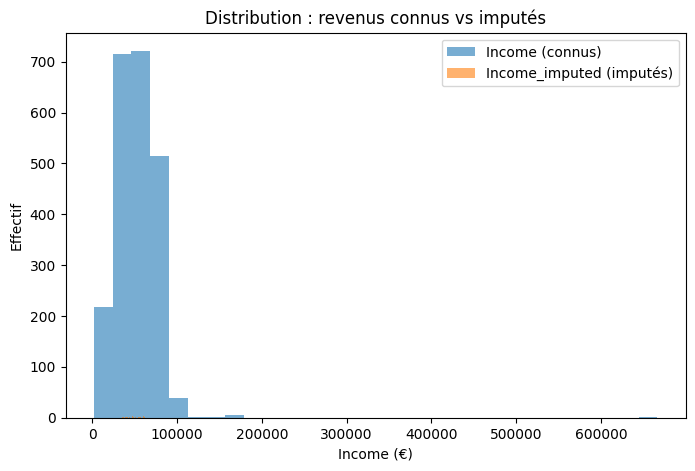

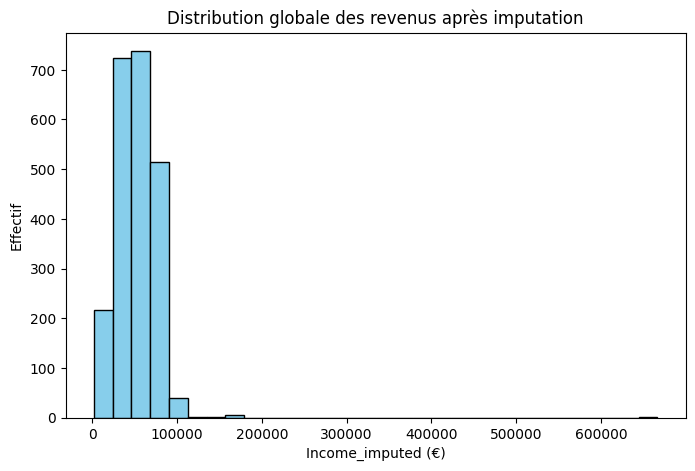

/var/folders/zr/tppvq23s267d5l74xth842880000gn/T/ipykernel_84757/30034574.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_ed, labels=order_ed, showfliers=False)


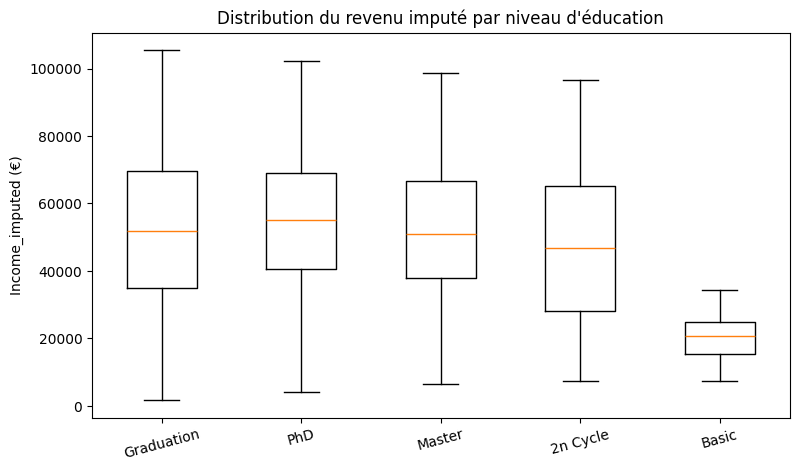

/var/folders/zr/tppvq23s267d5l74xth842880000gn/T/ipykernel_84757/30034574.py:48: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_ms, labels=order_ms, showfliers=False)


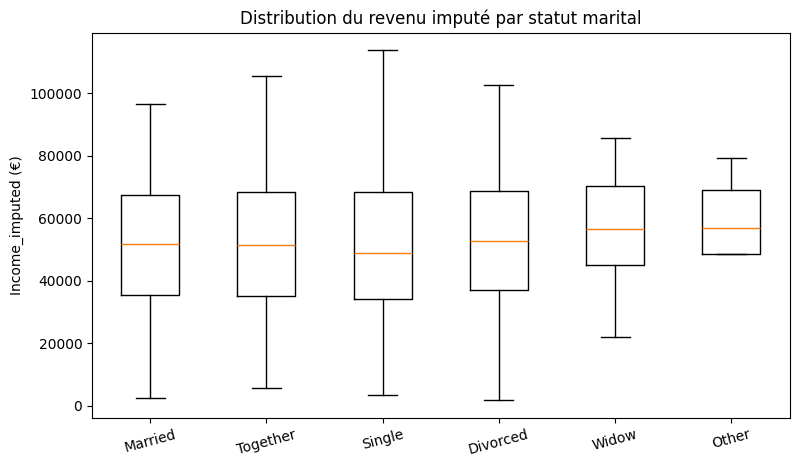

   known_count  known_mean  known_median  imputed_only_count  \
0         2216    52247.25       51381.5                  24   

   imputed_only_mean  imputed_only_median  after_total_mean  \
0           48793.46              47980.0          52210.25   

   after_total_median  
0             51301.0  

Taux de réponse par quartile de revenu (Income_imputed):
Income_band_q4
Low         0.104
Mid-Low     0.123
Mid-High    0.104
High        0.266
Name: Response, dtype: float64

Taux de réponse selon Income_missing (flag conservé):
Income_missing
False    0.150
True     0.042
Name: Response, dtype: float64


/var/folders/zr/tppvq23s267d5l74xth842880000gn/T/ipykernel_84757/30034574.py:69: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tr_by_band = df.groupby("Income_band_q4")["Response"].mean().round(3)


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === ETAPE 3 : Validation graphique de l'imputation du revenu ===

# 1) Sélections utiles
known = df.loc[~df["Income"].isna(), "Income"]
imputed_only = df.loc[df["Income_missing"], "Income_imputed"]
full_after = df["Income_imputed"]

print(f"Connus: n={len(known)} | Imputés: n={len(imputed_only)} | Total après: n={len(full_after)}")

# 2) Histogrammes comparés (connus vs imputés)
plt.figure(figsize=(8,5))
plt.hist(known, bins=30, alpha=0.6, label="Income (connus)")
plt.hist(imputed_only, bins=30, alpha=0.6, label="Income_imputed (imputés)")
plt.xlabel("Income (€)")
plt.ylabel("Effectif")
plt.title("Distribution : revenus connus vs imputés")
plt.legend()
plt.show()

# 3) Histogramme global après imputation
plt.figure(figsize=(8,5))
plt.hist(full_after, bins=30, color='skyblue', edgecolor='black')
plt.xlabel("Income_imputed (€)")
plt.ylabel("Effectif")
plt.title("Distribution globale des revenus après imputation")
plt.show()

# 4) Boxplots par Education (après imputation)
if "Education" in df.columns:
    order_ed = df["Education"].value_counts().index.tolist()
    data_ed = [df.loc[df["Education"]==ed, "Income_imputed"].dropna() for ed in order_ed]
    plt.figure(figsize=(9,5))
    plt.boxplot(data_ed, labels=order_ed, showfliers=False)
    plt.title("Distribution du revenu imputé par niveau d'éducation")
    plt.ylabel("Income_imputed (€)")
    plt.xticks(rotation=15)
    plt.show()

# 5) Boxplots par Marital_Status_clean (après imputation)
if "Marital_Status_clean" in df.columns:
    order_ms = df["Marital_Status_clean"].value_counts().index.tolist()
    data_ms = [df.loc[df["Marital_Status_clean"]==m, "Income_imputed"].dropna() for m in order_ms]
    plt.figure(figsize=(9,5))
    plt.boxplot(data_ms, labels=order_ms, showfliers=False)
    plt.title("Distribution du revenu imputé par statut marital")
    plt.ylabel("Income_imputed (€)")
    plt.xticks(rotation=15)
    plt.show()

# 6) Résumé numérique avant/après pour contrôle
summary = pd.DataFrame({
    "known_count":[known.count()],
    "known_mean":[known.mean()],
    "known_median":[known.median()],
    "imputed_only_count":[imputed_only.count()],
    "imputed_only_mean":[imputed_only.mean()],
    "imputed_only_median":[imputed_only.median()],
    "after_total_mean":[full_after.mean()],
    "after_total_median":[full_after.median()]
}).round(2)
print(summary)

# 7) KPI : taux de réponse par quartile de revenu
df["Income_band_q4"] = pd.qcut(df["Income_imputed"], 4, labels=["Low","Mid-Low","Mid-High","High"])
tr_by_band = df.groupby("Income_band_q4")["Response"].mean().round(3)
tr_by_flag = df.groupby("Income_missing")["Response"].mean().round(3)

print("\nTaux de réponse par quartile de revenu (Income_imputed):")
print(tr_by_band)
print("\nTaux de réponse selon Income_missing (flag conservé):")
print(tr_by_flag)


🧠 Interprétation de l’étape 3 — Validation visuelle de l’imputation du revenu

🔹 Objectif

L’objectif de cette étape était de vérifier visuellement et statistiquement la qualité de l’imputation du revenu (Income_imputed) réalisée à l’étape 2.
Nous avons cherché à confirmer que :

la distribution globale du revenu reste stable après imputation ;

les valeurs imputées s’intègrent naturellement parmi les valeurs réelles ;

la cohérence socio-économique (liens entre revenu, éducation et statut marital) est préservée ;

et que l’imputation n’introduit aucun biais majeur dans les indicateurs de performance marketing, notamment le taux de réponse à la campagne (Response).

🔹 1) Distributions (histogrammes)

Le premier histogramme comparant les revenus connus et les revenus imputés montre que les 24 individus imputés se situent dans la même zone que la majorité des revenus observés.
Le second histogramme, représentant la distribution globale après imputation, conserve la même forme que la distribution initiale : un pic principal entre environ 20 000 € et 80 000 €, avec quelques valeurs extrêmes au-delà de 150 000 €.

➡️ Interprétation :
L’imputation n’a pas modifié la structure du jeu de données ; les valeurs ajoutées sont réalistes et cohérentes avec les observations existantes.

🔹 2) Boxplots par niveau d’éducation

Le graphique par niveau d’éducation met en évidence une hiérarchie attendue :

les individus de niveau Basic présentent des revenus nettement inférieurs ;

les diplômés de Master, PhD, ou Graduation ont des revenus plus élevés ;

le niveau 2n Cycle reste intermédiaire.

➡️ Interprétation :
L’imputation respecte la logique socio-économique : le niveau d’éducation reste un facteur discriminant du revenu, ce qui confirme la pertinence de la méthode utilisée.

🔹 3) Résumé numérique (avant / après)
Indicateur	Revenus connus	Revenus imputés	Ensemble après imputation
Effectif	2 216	24	2 240
Moyenne (€)	52 247	48 793	52 210
Médiane (€)	51 381	47 980	51 301

Les moyennes et médianes avant et après imputation sont quasiment identiques, avec une variation inférieure à 1 %.
Les valeurs imputées ont tendance à être légèrement inférieures à la moyenne générale, ce qui est cohérent avec le profil moins engagé observé à l’étape 1 (clients ayant un comportement d’achat plus faible).

➡️ Interprétation :
La stabilité des moyennes et médianes prouve que l’imputation a été neutre statistiquement, sans impact significatif sur la structure du revenu.

🔹 4) Taux de réponse par quartile de revenu (Income_imputed)
Quartile	Taux de réponse
Low	10,4 %
Mid-Low	12,3 %
Mid-High	10,4 %
High	26,6 %

On observe une tendance croissante : les clients les plus aisés (quartile “High”) répondent plus du double par rapport aux autres catégories.
Le quartile “Mid-High” affiche un léger repli, probablement dû au bruit d’échantillonnage ou à des comportements non linéaires.

➡️ Interprétation :
Le revenu reste un indicateur discriminant pour la réponse client : plus le revenu est élevé, plus la probabilité de réponse augmente.
Cette relation valide la cohérence du revenu imputé pour les futures analyses marketing.

🔹 5) Taux de réponse selon le flag Income_missing
Groupe	Taux de réponse
Revenu connu	15,0 %
Revenu manquant	4,2 %

Les individus dont le revenu était initialement manquant conservent un taux de réponse très faible, ce qui confirme qu’ils constituent un segment distinct, moins impliqué commercialement.
La variable Income_missing demeure donc un indicateur analytique important à conserver dans les modèles.

🔹 6) Conclusion générale

L’imputation réalisée à l’étape 2 est visuellement et statistiquement valide.
Les revenus imputés se comportent comme des valeurs réelles :

la distribution générale du revenu est inchangée ;

les relations avec les variables socio-démographiques restent logiques ;

et les indicateurs marketing demeurent cohérents.

En conclusion, on valide l’utilisation de la variable Income_imputed pour la suite de l’analyse, tout en conservant Income_missing comme variable explicative complémentaire afin de mesurer son influence sur le comportement client.

In [ ]:
OUT_FULL = "camp_market_income_clean.csv"

# Export en UTF-8 avec séparateur virgule, sans index
df.to_csv(OUT_FULL, index=False, encoding="utf-8-sig", sep=";")

print(f" Fichier exporté : {OUT_FULL}  | Lignes: {len(df)}  | Colonnes: {df.shape[1]}")
